### Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
sns.set_style("darkgrid")

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Preparation

In [3]:
tools = pd.read_parquet('../data/tools.parquet')
fpmms = pd.read_parquet('../data/fpmms.parquet')
summary_traders = pd.read_parquet('../data/summary_profitability.parquet')


In [6]:
all_trades = pd.read_parquet('../data/all_trades_profitability.parquet')

In [7]:
all_trades.head()

trader_address  \
0  0x022b36c50b85b8ae7addfb8a35d76c59d5814834   
1  0x022b36c50b85b8ae7addfb8a35d76c59d5814834   
2  0x022b36c50b85b8ae7addfb8a35d76c59d5814834   
3  0x022b36c50b85b8ae7addfb8a35d76c59d5814834   
4  0x022b36c50b85b8ae7addfb8a35d76c59d5814834   

                                            trade_id  \
0  0x017947579ab51313c31fe1cc562c0f1726ec09c90x02...   
1  0x027f6bc849e273477f4a63085192714084917fcc0x02...   
2  0x027f6bc849e273477f4a63085192714084917fcc0x02...   
3  0x027f6bc849e273477f4a63085192714084917fcc0x02...   
4  0x027f6bc849e273477f4a63085192714084917fcc0x02...   

         creation_timestamp  \
0 2024-05-19 01:26:30+00:00   
1 2024-06-12 01:16:55+00:00   
2 2024-06-12 15:08:00+00:00   
3 2024-06-13 07:22:55+00:00   
4 2024-06-14 03:01:20+00:00   

                                               title market_status  \
0  Will Google's Pixel 9 lineup be officially rel...        CLOSED   
1  Will the 2D-animated Paramount Plus show 'Tale...        CLOSED   
2  Will the 2D-animated Paramount Plus show 'Tale...        CLOSED   
3  Will the 2D-animated Paramount Plus show 'Tale...        CLOSED   
4  Will the 2D-animated Paramount Plus show 'Tale...        CLOSED   

   collateral_amount outcome_index  trade_fee_amount  outcomes_tokens_traded  \
0              0.638             1             0.013                   1.206   
1              1.000             1             0.020                   1.840   
2              0.800             1             0.016                   1.518   
3              0.456             0             0.009                   1.003   
4              0.704             0             0.014                   1.198   

   current_answer  is_invalid  winning_trade  earnings  redeemed  \
0               1       False           True     1.206      True   
1               1       False           True     1.840      True   
2               1       False           True     1.518      True   
3               1       False          False     0.000      True   
4               1       False          False     0.000      True   

   redeemed_amount  num_mech_calls  mech_fee_amount  net_earnings    roi  
0            1.206               0            0.000         0.556  0.854  
1            1.840               5            0.050         0.770  0.719  
2            1.518               5            0.050         0.652  0.753  
3            0.000               5            0.050        -0.515 -1.000  
4            0.000               5            0.050        -0.768 -1.000

In [4]:
all_trades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [8]:
all_trades.creation_timestamp.min()

Timestamp('2024-05-12 00:04:25+0000', tz='UTC')

In [9]:
all_trades.creation_timestamp.max()

Timestamp('2024-07-08 02:29:40+0000', tz='UTC')

In [4]:
print(tools.shape)
tools.request_block.min(), tools.request_block.max()

(339443, 22)


(28911882, 34138429)

### 1. Error analysis

Error analysis only starts from block 321. We weren't capturing the error message prior

In [5]:
tools.tool.unique()

array(['prediction-online', 'prediction-offline', 'normal-sme-generator',
       'strong-sme-generator', 'prediction-online-sme',
       'prediction-offline-sme', 'claude-prediction-offline', 'openai',
       'claude-prediction-online',
       'prediction-sentence-embedding-conservative',
       'prediction-online-summarized-info',
       'prediction-sentence-embedding-bold',
       'prediction-online-sum-url-content',
       'openai-gpt-3.5-turbo-instruct',
       'resolve-market-reasoning-gpt-3.5-turbo',
       'resolve-market-reasoning-gpt-4', 'prediction-request-rag',
       'prediction-request-reasoning',
       'prediction-request-reasoning-claude', 'prediction-url-cot-claude',
       'prediction-request-rag-claude', 'native_transfer_request',
       'native_transfer'], dtype=object)

In [5]:
tools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339443 entries, 0 to 339442
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   request_id               339443 non-null  object 
 1   request_block            339443 non-null  int64  
 2   prompt_request           339443 non-null  object 
 3   tool                     339443 non-null  object 
 4   nonce                    339443 non-null  object 
 5   trader_address           339443 non-null  object 
 6   deliver_block            339443 non-null  int64  
 7   error                    339440 non-null  float64
 8   error_message            56715 non-null   object 
 9   prompt_response          252711 non-null  object 
 10  mech_address             286960 non-null  object 
 11  p_yes                    282717 non-null  float64
 12  p_no                     282717 non-null  float64
 13  confidence               282717 non-null  float64
 14  info

In [6]:
tools.request_time.min()

'2023-07-12 11:58:40'

In [4]:
inc_tools = [
    'prediction-online', 
    'prediction-offline', 
    'claude-prediction-online', 
    'claude-prediction-offline', 
    'prediction-offline-sme',
    'prediction-online-sme',
    'prediction-request-rag',
    'prediction-request-reasoning',
    'prediction-url-cot-claude', 
    'prediction-request-rag-claude',
    'prediction-request-reasoning-claude'
]

In [8]:
# include only tools that are in inc_tools
tools_inc = tools[tools['tool'].isin(inc_tools)]

In [9]:
error = tools_inc.groupby(['tool', 'request_month_year_week', 'error']).size().unstack().fillna(0).reset_index()
error["error_perc"] = (error[1] / (error[0] + error[1])) * 100
error["total_requests"] = error[0] + error[1]

In [13]:
error_total = (
    error.groupby("request_month_year_week")
    .agg({"total_requests": "sum", 1: "sum", 0: "sum"})
    .reset_index()
)
error_total["error_perc"] = (error_total[1] / error_total["total_requests"]) * 100
error_total.columns = error_total.columns.astype(str)
error_total["error_perc"] = error_total["error_perc"].apply(lambda x: round(x, 4))

In [15]:
error_total.head()

error request_month_year_week  total_requests       1       0  error_perc
0       2023-07-10/2023-07-16          44.000  31.000  13.000      70.454
1       2023-07-17/2023-07-23          56.000   0.000  56.000       0.000
2       2023-07-24/2023-07-30          48.000   5.000  43.000      10.417
3       2023-07-31/2023-08-06         922.000 203.000 719.000      22.017
4       2023-08-07/2023-08-13         313.000   9.000 304.000       2.875

Text(0.5, 1.0, 'Error Percentage by Month-Year')

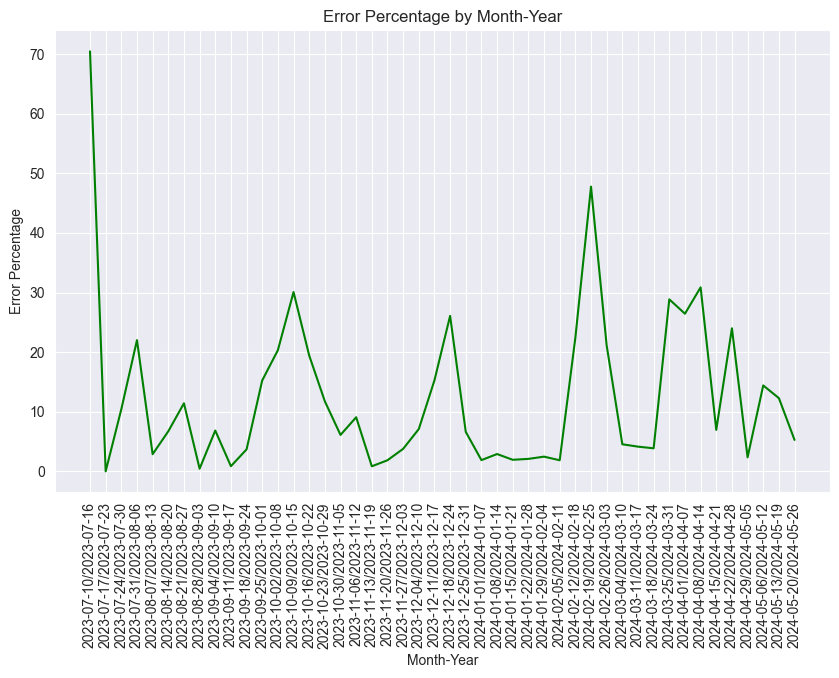

In [25]:
plt.figure(figsize=(10, 6))
ax=sns.lineplot(error_total, x='request_month_year_week', y='error_perc',color="green")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel('Month-Year')
plt.ylabel('Error Percentage')
plt.title('Error Percentage by Month-Year')

In [27]:
error[error['request_month_year_week'] == '2024-05-20/2024-05-26'].groupby('tool').agg({'error_perc': 'mean', 'total_requests': 'sum'}).sort_values('error_perc', ascending=False)

error                                error_perc  total_requests
tool                                                           
prediction-request-rag-claude            13.498        1704.000
prediction-request-rag                   12.041         490.000
prediction-online-sme                     9.076        2457.000
prediction-online                         4.769        2516.000
prediction-request-reasoning              3.247        5883.000
prediction-request-reasoning-claude       1.408         639.000
claude-prediction-offline                 0.000         107.000
claude-prediction-online                  0.000         241.000
prediction-offline                        0.000        1453.000
prediction-url-cot-claude                 0.000         293.000

In [30]:
# clude-prediction-offline
claude_prediction_offline = error[error['tool'] == 'claude-prediction-offline']
claude_prediction_offline = claude_prediction_offline.sort_values('request_month_year_week', ascending=False)
claude_prediction_offline.head()

error                       tool  request_month_year_week   0.000  1.000  \
19     claude-prediction-offline    2024-05-20/2024-05-26 107.000  0.000   
18     claude-prediction-offline    2024-05-13/2024-05-19 203.000  0.000   
17     claude-prediction-offline    2024-05-06/2024-05-12 156.000  0.000   
16     claude-prediction-offline    2024-04-29/2024-05-05 531.000  0.000   
15     claude-prediction-offline    2024-04-22/2024-04-28 816.000  5.000   

error   error_perc   total_requests  
19           0.000          107.000  
18           0.000          203.000  
17           0.000          156.000  
16           0.000          531.000  
15           0.609          821.000

In [31]:
# claude-prediction-online
claude_prediction_online = error[error['tool'] == 'claude-prediction-online']
claude_prediction_online = claude_prediction_online.sort_values('request_month_year_week', ascending=False)
claude_prediction_online.head()

error                      tool  request_month_year_week    0.000   1.000  \
54     claude-prediction-online    2024-05-20/2024-05-26  241.000   0.000   
53     claude-prediction-online    2024-05-13/2024-05-19   37.000   0.000   
52     claude-prediction-online    2024-05-06/2024-05-12  176.000   0.000   
51     claude-prediction-online    2024-04-29/2024-05-05  192.000   0.000   
50     claude-prediction-online    2024-04-22/2024-04-28 1937.000 155.000   

error   error_perc   total_requests  
54           0.000          241.000  
53           0.000           37.000  
52           0.000          176.000  
51           0.000          192.000  
50           7.409         2092.000

In [32]:
# prediction-offline
prediction_offline = error[error['tool'] == 'prediction-offline']
prediction_offline = prediction_offline.sort_values('request_month_year_week', ascending=False)
prediction_offline.head()


error                tool  request_month_year_week    0.000   1.000  \
84     prediction-offline    2024-05-20/2024-05-26 1453.000   0.000   
83     prediction-offline    2024-05-13/2024-05-19 4270.000   1.000   
82     prediction-offline    2024-05-06/2024-05-12 2500.000   0.000   
81     prediction-offline    2024-04-29/2024-05-05 1825.000   2.000   
80     prediction-offline    2024-04-22/2024-04-28  381.000 375.000   

error   error_perc   total_requests  
84           0.000         1453.000  
83           0.023         4271.000  
82           0.000         2500.000  
81           0.109         1827.000  
80          49.603          756.000

In [33]:
# prediction-online
prediction_online = error[error['tool'] == 'prediction-online']
prediction_online = prediction_online.sort_values('request_month_year_week', ascending=False)
prediction_online.head()

error               tool  request_month_year_week    0.000   1.000  \
139    prediction-online    2024-05-20/2024-05-26 2396.000 120.000   
138    prediction-online    2024-05-13/2024-05-19 2642.000 393.000   
137    prediction-online    2024-05-06/2024-05-12 2840.000 266.000   
136    prediction-online    2024-04-29/2024-05-05 2155.000  24.000   
135    prediction-online    2024-04-22/2024-04-28  252.000 153.000   

error   error_perc   total_requests  
139          4.769         2516.000  
138         12.949         3035.000  
137          8.564         3106.000  
136          1.101         2179.000  
135         37.778          405.000

In [34]:
# prediction-offline-sme
prediction_offline_sme = error[error['tool'] == 'prediction-offline-sme']
prediction_offline_sme = prediction_offline_sme.sort_values('request_month_year_week', ascending=False)
prediction_offline_sme.head()

error                    tool  request_month_year_week   0.000  1.000  \
104    prediction-offline-sme    2024-04-29/2024-05-05   8.000  0.000   
103    prediction-offline-sme    2024-04-22/2024-04-28 159.000  2.000   
102    prediction-offline-sme    2024-04-15/2024-04-21 717.000  2.000   
101    prediction-offline-sme    2024-04-08/2024-04-14   4.000  0.000   
100    prediction-offline-sme    2024-04-01/2024-04-07 197.000  1.000   

error   error_perc   total_requests  
104          0.000            8.000  
103          1.242          161.000  
102          0.278          719.000  
101          0.000            4.000  
100          0.505          198.000

In [35]:
# prediction-online-sme
prediction_online_sme = error[error['tool'] == 'prediction-online-sme']
prediction_online_sme = prediction_online_sme.sort_values('request_month_year_week', ascending=False)
prediction_online_sme.head()

error                   tool  request_month_year_week    0.000    1.000  \
175    prediction-online-sme    2024-05-20/2024-05-26 2234.000  223.000   
174    prediction-online-sme    2024-05-13/2024-05-19 3141.000  668.000   
173    prediction-online-sme    2024-05-06/2024-05-12 3799.000  562.000   
172    prediction-online-sme    2024-04-29/2024-05-05 2534.000    6.000   
171    prediction-online-sme    2024-04-22/2024-04-28 2679.000 1075.000   

error   error_perc   total_requests  
175          9.076         2457.000  
174         17.537         3809.000  
173         12.887         4361.000  
172          0.236         2540.000  
171         28.636         3754.000

In [36]:
# prediction-request-rag
prediction_request_rag = error[error['tool'] == 'prediction-request-rag']
prediction_request_rag = prediction_request_rag.sort_values('request_month_year_week', ascending=False)
prediction_request_rag.head()

error                    tool  request_month_year_week    0.000   1.000  \
188    prediction-request-rag    2024-05-20/2024-05-26  431.000  59.000   
187    prediction-request-rag    2024-05-13/2024-05-19  355.000  55.000   
186    prediction-request-rag    2024-05-06/2024-05-12  470.000 125.000   
185    prediction-request-rag    2024-04-29/2024-05-05  544.000   0.000   
184    prediction-request-rag    2024-04-22/2024-04-28 2011.000 881.000   

error   error_perc   total_requests  
188         12.041          490.000  
187         13.415          410.000  
186         21.008          595.000  
185          0.000          544.000  
184         30.463         2892.000

In [37]:
# prediction-request-reasoning-claude
prediction_request_reasoning_claude = error[error['tool'] == 'prediction-request-reasoning-claude']
prediction_request_reasoning_claude = prediction_request_reasoning_claude.sort_values('request_month_year_week', ascending=False)
prediction_request_reasoning_claude.head()

error                                 tool  request_month_year_week    0.000  \
214    prediction-request-reasoning-claude    2024-05-20/2024-05-26  630.000   
213    prediction-request-reasoning-claude    2024-05-13/2024-05-19  309.000   
212    prediction-request-reasoning-claude    2024-05-06/2024-05-12  478.000   
211    prediction-request-reasoning-claude    2024-04-29/2024-05-05  218.000   
210    prediction-request-reasoning-claude    2024-04-22/2024-04-28 2053.000   

error   1.000   error_perc   total_requests  
214     9.000        1.408          639.000  
213   205.000       39.883          514.000  
212    54.000       10.150          532.000  
211     8.000        3.540          226.000  
210   575.000       21.880         2628.000

In [38]:
prediction_request_rag_claude = error[error['tool'] == 'prediction-request-rag-claude']
prediction_request_rag_claude = prediction_request_rag_claude.sort_values('request_month_year_week', ascending=False)
prediction_request_rag_claude.head()

error                           tool  request_month_year_week    0.000  \
196    prediction-request-rag-claude    2024-05-20/2024-05-26 1474.000   
195    prediction-request-rag-claude    2024-05-13/2024-05-19 2378.000   
194    prediction-request-rag-claude    2024-05-06/2024-05-12 2850.000   
193    prediction-request-rag-claude    2024-04-29/2024-05-05 1313.000   
192    prediction-request-rag-claude    2024-04-22/2024-04-28 1113.000   

error   1.000   error_perc   total_requests  
196   230.000       13.498         1704.000  
195   274.000       10.332         2652.000  
194   777.000       21.423         3627.000  
193     8.000        0.606         1321.000  
192   345.000       23.663         1458.000

In [39]:
prediction_url_cot_claude = error[error['tool'] == 'prediction-url-cot-claude']
prediction_url_cot_claude = prediction_url_cot_claude.sort_values('request_month_year_week', ascending=False)
prediction_url_cot_claude.head()

error                       tool  request_month_year_week    0.000  1.000  \
222    prediction-url-cot-claude    2024-05-20/2024-05-26  293.000  0.000   
221    prediction-url-cot-claude    2024-05-13/2024-05-19   93.000  0.000   
220    prediction-url-cot-claude    2024-05-06/2024-05-12  225.000  0.000   
219    prediction-url-cot-claude    2024-04-29/2024-05-05  270.000  0.000   
218    prediction-url-cot-claude    2024-04-22/2024-04-28 1506.000 65.000   

error   error_perc   total_requests  
222          0.000          293.000  
221          0.000           93.000  
220          0.000          225.000  
219          0.000          270.000  
218          4.137         1571.000

In [7]:
del tools
del tools_inc
del error
del error_total

gc.collect()

NameError: name 'tools_inc' is not defined

### 2. Win analysis

In [45]:
# only include non error requests
tools_non_error = tools_inc[tools_inc['error'] != 1]
tools_non_error['currentAnswer'].replace('no', 'No', inplace=True)
tools_non_error['currentAnswer'].replace('yes', 'Yes', inplace=True)
tools_non_error = tools_non_error[tools_non_error['currentAnswer'].isin(['Yes', 'No'])]
tools_non_error = tools_non_error[tools_non_error['vote'].isin(['Yes', 'No'])]

In [46]:
tools_non_error['win'] = tools_non_error['currentAnswer'] == tools_non_error['vote']
tools_non_error['win'] = tools_non_error['win'].astype(int)

In [47]:
wins = tools_non_error.groupby(['tool', 'request_month_year_week', 'win']).size().unstack().fillna(0)
wins['win_perc'] = (wins[1] / (wins[0] + wins[1]))*100
wins.reset_index(inplace=True)
wins['total_request'] = wins[0] + wins[1]

In [48]:
wins['tool'].unique()

array(['claude-prediction-offline', 'claude-prediction-online',
       'prediction-offline', 'prediction-offline-sme',
       'prediction-online', 'prediction-online-sme',
       'prediction-request-rag', 'prediction-request-rag-claude',
       'prediction-request-reasoning',
       'prediction-request-reasoning-claude', 'prediction-url-cot-claude'],
      dtype=object)

In [49]:
wins.groupby('request_month_year_week').agg({
    0: 'sum',
    1: 'sum',
    'win_perc': 'mean',
    'total_request': 'sum'
})

win                            0        1  win_perc  total_request
request_month_year_week                                           
2023-07-17/2023-07-23      1.000    1.000    50.000          2.000
2023-07-24/2023-07-30     12.000   12.000    50.000         24.000
2023-07-31/2023-08-06    360.000  229.000    41.979        589.000
2023-08-07/2023-08-13    177.000  110.000    44.123        287.000
2023-08-14/2023-08-20    784.000  559.000    41.623       1343.000
2023-08-21/2023-08-27    596.000  502.000    45.719       1098.000
2023-08-28/2023-09-03    958.000  502.000    34.384       1460.000
2023-09-04/2023-09-10   1609.000 1418.000    46.845       3027.000
2023-09-11/2023-09-17   1171.000 1380.000    54.096       2551.000
2023-09-18/2023-09-24   2150.000 2307.000    60.968       4457.000
2023-09-25/2023-10-01    992.000  817.000    47.635       1809.000
2023-10-02/2023-10-08   1625.000 1842.000    54.240       3467.000
2023-10-09/2023-10-15   1594.000 2096.000    57.281       3690.000
2023-10-16/2023-10-22   1291.000 1623.000    55.496       2914.000
2023-10-23/2023-10-29   1018.000 1084.000    50.802       2102.000
2023-10-30/2023-11-05    541.000  825.000    64.848       1366.000
2023-11-06/2023-11-12   1545.000 1776.000    69.014       3321.000
2023-11-13/2023-11-19   1825.000 2056.000    55.202       3881.000
2023-11-20/2023-11-26   1567.000 1874.000    58.482       3441.000
2023-11-27/2023-12-03   1555.000 1773.000    67.721       3328.000
2023-12-04/2023-12-10   1245.000 1470.000    33.705       2715.000
2023-12-11/2023-12-17   1462.000 1788.000    52.404       3250.000
2023-12-18/2023-12-24   1332.000 1557.000    46.687       2889.000
2023-12-25/2023-12-31   1397.000 1257.000    48.222       2654.000
2024-01-01/2024-01-07   2159.000 1713.000    43.436       3872.000
2024-01-08/2024-01-14   1034.000  890.000    41.597       1924.000
2024-01-15/2024-01-21   2228.000 1758.000    40.827       3986.000
2024-01-22/2024-01-28   2036.000 1970.000    31.617       4006.000
2024-01-29/2024-02-04   2303.000 1791.000    37.106       4094.000
2024-02-05/2024-02-11   2149.000 2189.000    49.808       4338.000
2024-02-12/2024-02-18   1979.000 1956.000    55.949       3935.000
2024-02-19/2024-02-25   1788.000 2002.000    57.697       3790.000
2024-02-26/2024-03-03   2299.000 2350.000    42.051       4649.000
2024-03-04/2024-03-10   4523.000 3500.000    44.989       8023.000
2024-03-11/2024-03-17   4516.000 4705.000    56.713       9221.000
2024-03-18/2024-03-24   5561.000 5581.000    52.903      11142.000
2024-03-25/2024-03-31   5200.000 6965.000    54.644      12165.000
2024-04-01/2024-04-07   2923.000 4258.000    61.323       7181.000
2024-04-08/2024-04-14   1331.000 3412.000    69.522       4743.000

In [50]:
# select only claude-prediction-online and plot request_month_year_week vs win_perc
claude_prediction_online = wins[wins['tool'] == 'claude-prediction-online']
claude_prediction_online = claude_prediction_online[['request_month_year_week', 'win_perc', 'total_request']]
claude_prediction_online = claude_prediction_online.sort_values(by='request_month_year_week')

claude_prediction_online.head()

win request_month_year_week  win_perc  total_request
11    2023-09-18/2023-09-24   100.000          1.000
12    2023-09-25/2023-10-01    58.333         48.000
13    2023-10-02/2023-10-08    61.783        157.000
14    2023-10-09/2023-10-15    60.588        680.000
15    2023-10-16/2023-10-22    58.791        364.000
16    2023-10-23/2023-10-29    47.143         70.000
17    2023-10-30/2023-11-05    67.647         34.000
18    2023-11-20/2023-11-26   100.000          1.000
19    2023-11-27/2023-12-03    57.143          7.000
20    2023-12-04/2023-12-10    66.667          6.000
21    2023-12-11/2023-12-17    50.000          2.000
22    2023-12-25/2023-12-31    55.814         43.000
23    2024-01-01/2024-01-07    28.400        250.000
24    2024-01-08/2024-01-14    35.789        190.000
25    2024-01-15/2024-01-21    36.986        292.000
26    2024-01-22/2024-01-28    45.387        271.000
27    2024-01-29/2024-02-04    29.555        247.000
28    2024-02-05/2024-02-11    49.064        267.000
29    2024-02-12/2024-02-18    63.300        297.000
30    2024-02-19/2024-02-25    65.362        690.000
31    2024-03-18/2024-03-24    71.575        781.000
32    2024-03-25/2024-03-31    69.052       3648.000
33    2024-04-01/2024-04-07    60.991       2402.000
34    2024-04-08/2024-04-14    62.205        635.000

In [51]:
# select only claude-prediction-offline and plot request_month_year_week vs win_perc
claude_prediction_offline = wins[wins['tool'] == 'claude-prediction-offline']
claude_prediction_offline = claude_prediction_offline[['request_month_year_week', 'win_perc', 'total_request']]
claude_prediction_offline = claude_prediction_offline.sort_values(by='request_month_year_week')

claude_prediction_offline.head()

win request_month_year_week  win_perc  total_request
0     2023-09-18/2023-09-24    16.667          6.000
1     2023-09-25/2023-10-01    53.205        156.000
2     2023-10-02/2023-10-08    53.333        285.000
3     2023-10-09/2023-10-15    60.477        377.000
4     2023-10-16/2023-10-22    57.854        522.000
5     2023-10-23/2023-10-29    56.383        376.000
6     2023-10-30/2023-11-05    72.000         75.000
7     2023-11-06/2023-11-12   100.000          1.000
8     2023-11-13/2023-11-19   100.000          2.000
9     2023-12-18/2023-12-24    20.000          5.000
10    2024-03-25/2024-03-31   100.000          2.000

In [52]:
# select only prediction-online and plot request_month_year_week vs win_perc
prediction_online = wins[wins['tool'] == 'prediction-online']
prediction_online = prediction_online[['request_month_year_week', 'win_perc', 'total_request']]
prediction_online = prediction_online.sort_values(by='request_month_year_week')

prediction_online.head()

win request_month_year_week  win_perc  total_request
72    2023-07-17/2023-07-23    50.000          2.000
73    2023-07-24/2023-07-30    50.000         24.000
74    2023-07-31/2023-08-06    38.306        543.000
75    2023-08-07/2023-08-13    38.246        285.000
76    2023-08-14/2023-08-20    41.623       1343.000
77    2023-08-21/2023-08-27    45.719       1098.000
78    2023-08-28/2023-09-03    34.384       1460.000
79    2023-09-04/2023-09-10    46.845       3027.000
80    2023-09-11/2023-09-17    54.096       2551.000
81    2023-09-18/2023-09-24    51.602       4246.000
82    2023-09-25/2023-10-01    43.876        743.000
83    2023-10-02/2023-10-08    50.538        837.000
84    2023-10-09/2023-10-15    50.976        973.000
85    2023-10-16/2023-10-22    56.146        903.000
86    2023-10-23/2023-10-29    48.822        594.000
87    2023-10-30/2023-11-05    60.392        664.000
88    2023-11-06/2023-11-12    52.533       1757.000
89    2023-11-13/2023-11-19    53.892       2004.000
90    2023-11-20/2023-11-26    53.202       1780.000
91    2023-11-27/2023-12-03    54.253       1058.000
92    2023-12-04/2023-12-10    47.500         80.000
93    2023-12-11/2023-12-17    52.174         23.000
94    2023-12-18/2023-12-24    69.863         73.000
95    2023-12-25/2023-12-31    41.509         53.000
96    2024-01-01/2024-01-07     0.000          2.000
97    2024-01-22/2024-01-28     0.000          1.000
98    2024-03-25/2024-03-31     0.000          1.000

In [53]:
# select only prediction-offline and plot request_month_year_week vs win_perc
prediction_offline = wins[wins['tool'] == 'prediction-offline']
prediction_offline = prediction_offline[['request_month_year_week', 'win_perc', 'total_request']]
prediction_offline = prediction_offline.sort_values(by='request_month_year_week')

prediction_offline

win request_month_year_week  win_perc  total_request
35    2023-07-31/2023-08-06    45.652         46.000
36    2023-08-07/2023-08-13    50.000          2.000
37    2023-09-18/2023-09-24    51.128        133.000
38    2023-09-25/2023-10-01    36.864        236.000
39    2023-10-02/2023-10-08    50.077        651.000
40    2023-10-09/2023-10-15    52.392        418.000
41    2023-10-16/2023-10-22    52.658        395.000
42    2023-10-23/2023-10-29    45.503        189.000
43    2023-10-30/2023-11-05    75.000         40.000
44    2023-11-13/2023-11-19    50.000          2.000
45    2023-11-20/2023-11-26    33.333          3.000
46    2023-11-27/2023-12-03    88.235         17.000
47    2023-12-04/2023-12-10     0.000          1.000
48    2023-12-18/2023-12-24    50.000          6.000
49    2024-01-01/2024-01-07   100.000          1.000
50    2024-03-11/2024-03-17    62.808        406.000
51    2024-03-18/2024-03-24    54.453       2448.000
52    2024-03-25/2024-03-31    58.729       2360.000
53    2024-04-01/2024-04-07    57.055        652.000
54    2024-04-08/2024-04-14    75.641        468.000

In [54]:
# select only prediction-offline-sme and plot request_month_year_week vs win_perc
prediction_offline_sme = wins[wins['tool'] == 'prediction-offline-sme']
prediction_offline_sme = prediction_offline_sme[['request_month_year_week', 'win_perc', 'total_request']]
prediction_offline_sme = prediction_offline_sme.sort_values(by='request_month_year_week')

prediction_offline_sme

win request_month_year_week  win_perc  total_request
55    2023-09-18/2023-09-24    83.333          6.000
56    2023-09-25/2023-10-01    45.545        303.000
57    2023-10-02/2023-10-08    54.208        701.000
58    2023-10-09/2023-10-15    58.883        591.000
59    2023-10-16/2023-10-22    54.407        329.000
60    2023-10-23/2023-10-29    51.064        517.000
61    2023-10-30/2023-11-05    60.265        302.000
62    2023-11-13/2023-11-19    20.000         10.000
63    2023-11-20/2023-11-26    50.000         14.000
64    2023-11-27/2023-12-03    86.667         15.000
65    2023-12-04/2023-12-10     0.000          1.000
66    2023-12-18/2023-12-24    40.000          5.000
67    2024-03-11/2024-03-17    60.947        169.000
68    2024-03-18/2024-03-24    44.016        493.000
69    2024-03-25/2024-03-31    60.000         10.000
70    2024-04-01/2024-04-07    61.039         77.000
71    2024-04-08/2024-04-14    50.000          2.000

In [55]:
# select only prediction-online-sme and plot request_month_year_week vs win_perc
prediction_online_sme = wins[wins['tool'] == 'prediction-online-sme']
prediction_online_sme = prediction_online_sme[['request_month_year_week', 'win_perc', 'total_request']]
prediction_online_sme = prediction_online_sme.sort_values(by='request_month_year_week')

prediction_online_sme.head()

win request_month_year_week  win_perc  total_request
99    2023-09-18/2023-09-24    63.077         65.000
100   2023-09-25/2023-10-01    47.988        323.000
101   2023-10-02/2023-10-08    55.502        836.000
102   2023-10-09/2023-10-15    60.369        651.000
103   2023-10-16/2023-10-22    53.117        401.000
104   2023-10-23/2023-10-29    55.899        356.000
105   2023-10-30/2023-11-05    53.785        251.000
106   2023-11-06/2023-11-12    54.511       1563.000
107   2023-11-13/2023-11-19    52.120       1863.000
108   2023-11-20/2023-11-26    55.873       1643.000
109   2023-11-27/2023-12-03    52.308       2231.000
110   2023-12-04/2023-12-10    54.359       2627.000
111   2023-12-11/2023-12-17    55.039       3225.000
112   2023-12-18/2023-12-24    53.571       2800.000
113   2023-12-25/2023-12-31    47.342       2558.000
114   2024-01-01/2024-01-07    45.344       3619.000
115   2024-01-08/2024-01-14    47.405       1734.000
116   2024-01-15/2024-01-21    44.667       3694.000
117   2024-01-22/2024-01-28    49.464       3734.000
118   2024-01-29/2024-02-04    44.658       3847.000
119   2024-02-05/2024-02-11    50.553       4071.000
120   2024-02-12/2024-02-18    48.598       3638.000
121   2024-02-19/2024-02-25    50.032       3100.000
122   2024-02-26/2024-03-03    51.717       4368.000
123   2024-03-04/2024-03-10    54.806       3454.000
124   2024-03-11/2024-03-17    55.848       3044.000
125   2024-03-18/2024-03-24    48.639       2535.000
126   2024-03-25/2024-03-31    41.345       1398.000
127   2024-04-01/2024-04-07    59.435       1097.000
128   2024-04-08/2024-04-14    68.281        413.000

In [56]:
# select only prediction-request-rag and plot request_month_year_week vs win_perc
prediction_request_rag = wins[wins['tool'] == 'prediction-request-rag']
prediction_request_rag = prediction_request_rag[['request_month_year_week', 'win_perc', 'total_request']]
prediction_request_rag = prediction_request_rag.sort_values(by='request_month_year_week')

prediction_request_rag.head()

win request_month_year_week  win_perc  total_request
129   2024-02-26/2024-03-03    32.384        281.000
130   2024-03-04/2024-03-10    35.172       4569.000
131   2024-03-11/2024-03-17    47.251       5602.000
132   2024-03-18/2024-03-24    45.834       4885.000
133   2024-03-25/2024-03-31    51.273       4006.000
134   2024-04-01/2024-04-07    57.021       1289.000
135   2024-04-08/2024-04-14    70.376        692.000

In [57]:
prediction_request_reasoning = wins[wins['tool'] == 'prediction-request-reasoning']
prediction_request_reasoning = prediction_request_reasoning[['request_month_year_week', 'win_perc', 'total_request']]
prediction_request_reasoning = prediction_request_reasoning.sort_values(by='request_month_year_week')

prediction_request_reasoning

win request_month_year_week  win_perc  total_request
138   2024-03-25/2024-03-31    56.757        740.000
139   2024-04-01/2024-04-07    58.025       1458.000
140   2024-04-08/2024-04-14    73.679       1003.000

In [58]:
prediction_request_reasoning_claude = wins[wins['tool'] == 'prediction-request-reasoning-claude']
prediction_request_reasoning_claude = prediction_request_reasoning_claude[['request_month_year_week', 'win_perc', 'total_request']]
prediction_request_reasoning_claude = prediction_request_reasoning_claude.sort_values(by='request_month_year_week')

prediction_request_reasoning_claude

win request_month_year_week  win_perc  total_request
141   2024-04-01/2024-04-07    68.387        155.000
142   2024-04-08/2024-04-14    78.514        619.000

In [59]:
prediction_request_rag_claude = wins[wins['tool'] == 'prediction-request-rag-claude']
prediction_request_rag_claude = prediction_request_rag_claude[['request_month_year_week', 'win_perc', 'total_request']]
prediction_request_rag_claude = prediction_request_rag_claude.sort_values(by='request_month_year_week')

prediction_request_rag_claude

win request_month_year_week  win_perc  total_request
136   2024-04-01/2024-04-07    68.627         51.000
137   2024-04-08/2024-04-14    74.184        337.000

In [60]:
prediction_url_cot_claude = wins[wins['tool'] == 'prediction-url-cot-claude']
prediction_url_cot_claude = prediction_url_cot_claude[['request_month_year_week', 'win_perc', 'total_request']]
prediction_url_cot_claude = prediction_url_cot_claude.sort_values(by='request_month_year_week')

prediction_url_cot_claude.head()

win request_month_year_week  win_perc  total_request
143   2024-04-08/2024-04-14    72.822        574.000

### 3. Profitability analysis

In [61]:
all_trades['creation_timestamp'] = pd.to_datetime(all_trades['creation_timestamp'])
all_trades = all_trades[all_trades['current_answer'].isin([0., 1., -1.])].reset_index(drop=True)

In [62]:
print(f"Number of traders: {len(summary_traders):,}")
print(f"Number of trades: {all_trades['trade_id'].nunique():,}")

Number of traders: 200
Number of trades: 72,724


Text(0, 0.5, 'Number of trades')

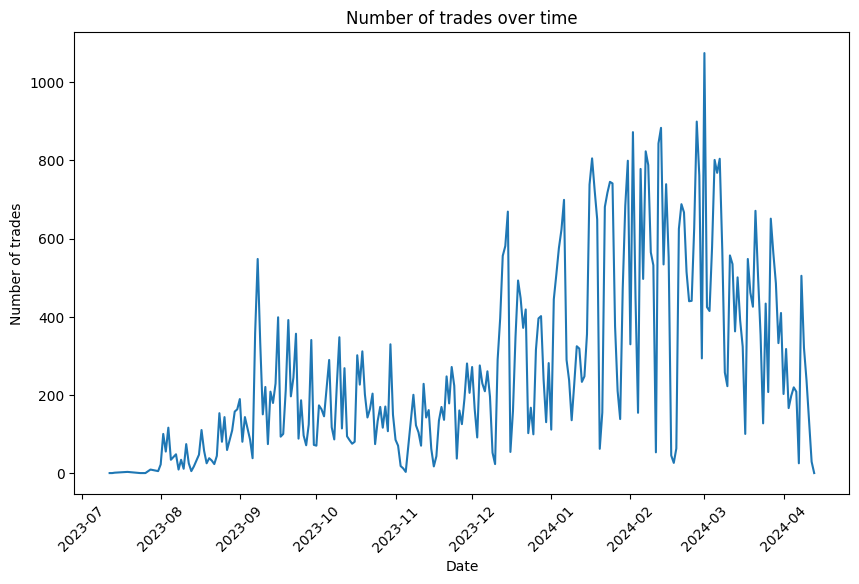

In [63]:
# plot num trades over time
plt.figure(figsize=(10,6))
all_trades['creation_timestamp'].dt.date.value_counts().sort_index().plot(title='Number of trades over time')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Number of trades')

In [64]:
print(all_trades['creation_timestamp'].min(), all_trades['creation_timestamp'].max())
all_trades['month_year'] = all_trades['creation_timestamp'].dt.to_period('M')
all_trades['month_year_week'] = all_trades['creation_timestamp'].dt.to_period('W')
all_trades['winning_trade'] = all_trades['winning_trade'].astype(int)

2023-07-12 15:17:25+00:00 2024-04-13 00:56:40+00:00


In [65]:
all_trades.columns

Index(['trader_address', 'trade_id', 'creation_timestamp', 'title',
       'market_status', 'collateral_amount', 'outcome_index',
       'trade_fee_amount', 'outcomes_tokens_traded', 'current_answer',
       'is_invalid', 'winning_trade', 'earnings', 'redeemed',
       'redeemed_amount', 'num_mech_calls', 'mech_fee_amount', 'net_earnings',
       'roi', 'month_year', 'month_year_week'],
      dtype='object')

In [66]:
all_trades.groupby(['month_year'])['winning_trade'].sum() / all_trades.groupby(['month_year'])['winning_trade'].count()

month_year
2023-07   0.385
2023-08   0.473
2023-09   0.442
2023-10   0.497
2023-11   0.488
2023-12   0.498
2024-01   0.470
2024-02   0.489
2024-03   0.499
2024-04   0.513
Freq: M, Name: winning_trade, dtype: float64

<Axes: title={'center': 'Winning trade percentage over time'}, xlabel='month_year_week'>

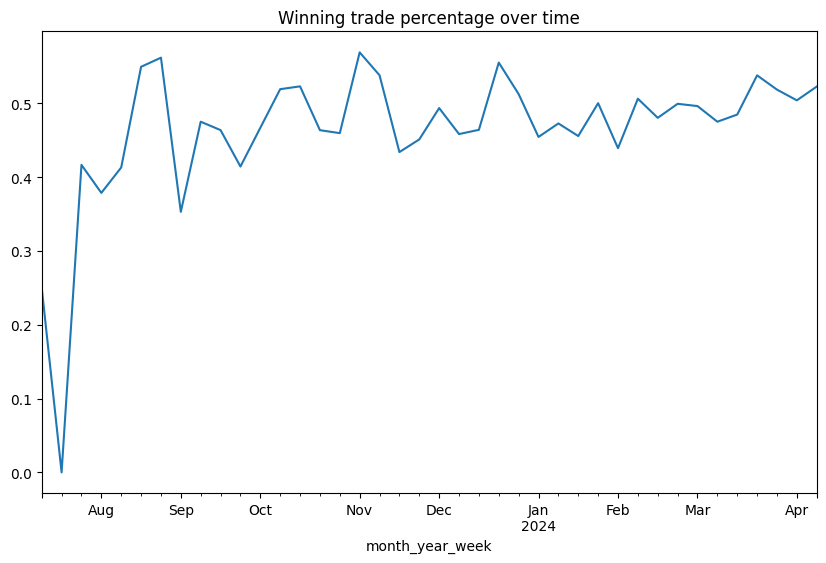

In [67]:
all_trades.groupby('month_year_week')['winning_trade'].mean().plot(title='Winning trade percentage over time', figsize=(10,6))

<Axes: title={'center': 'Mechanical calls over time'}, xlabel='month_year_week'>

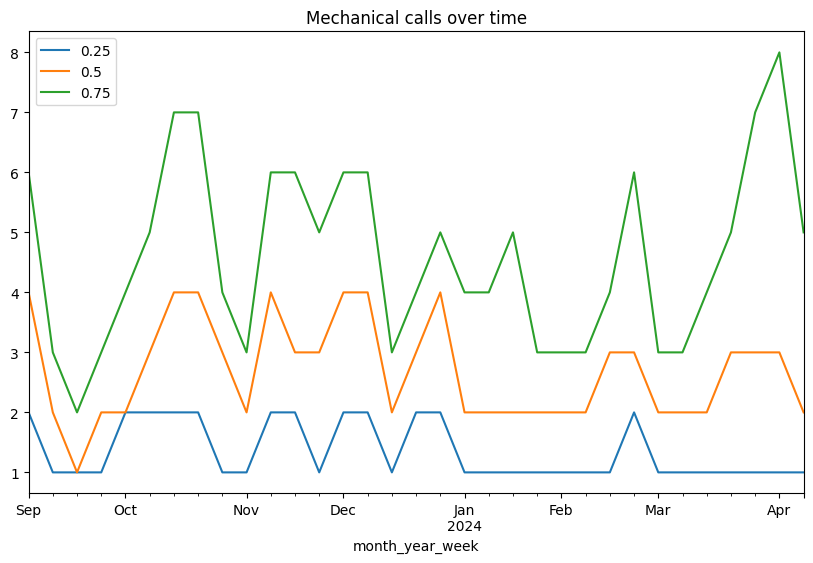

In [68]:
#only plot from september 2023
all_trades[all_trades['creation_timestamp'] > '2023-09-01'].groupby('month_year_week')['num_mech_calls'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Mechanical calls over time', figsize=(10,6)) 

<Axes: title={'center': 'Collateral amount quantiles over time'}, xlabel='month_year_week'>

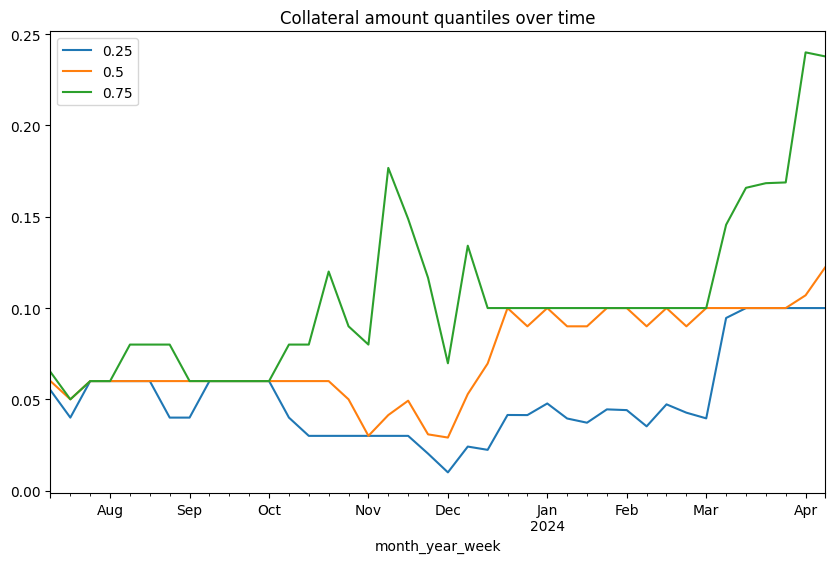

In [69]:
all_trades.groupby('month_year_week')['collateral_amount'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Collateral amount quantiles over time', figsize=(10,6))

<Axes: title={'center': 'Earnings quantiles over time'}, xlabel='month_year_week'>

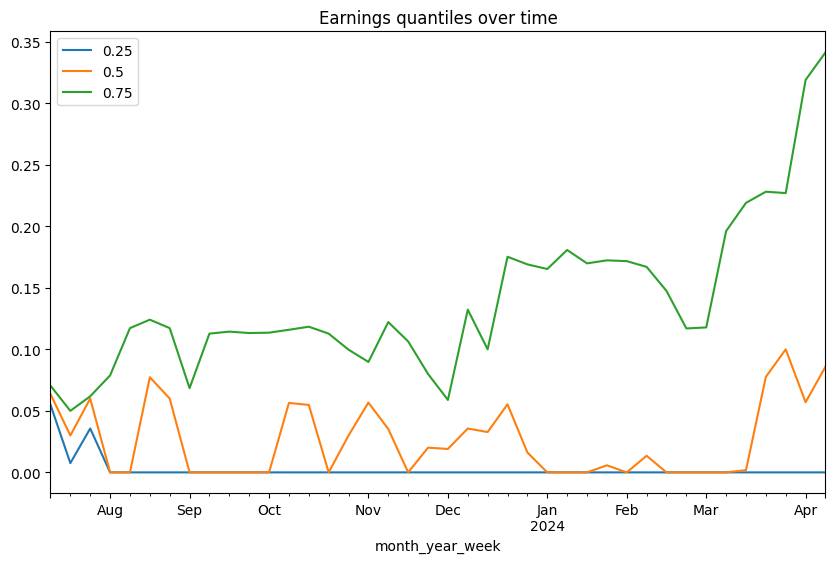

In [70]:
all_trades.groupby('month_year_week')['earnings'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Earnings quantiles over time', figsize=(10,6))

<Axes: title={'center': 'Net earnings quantiles over time'}, xlabel='month_year_week'>

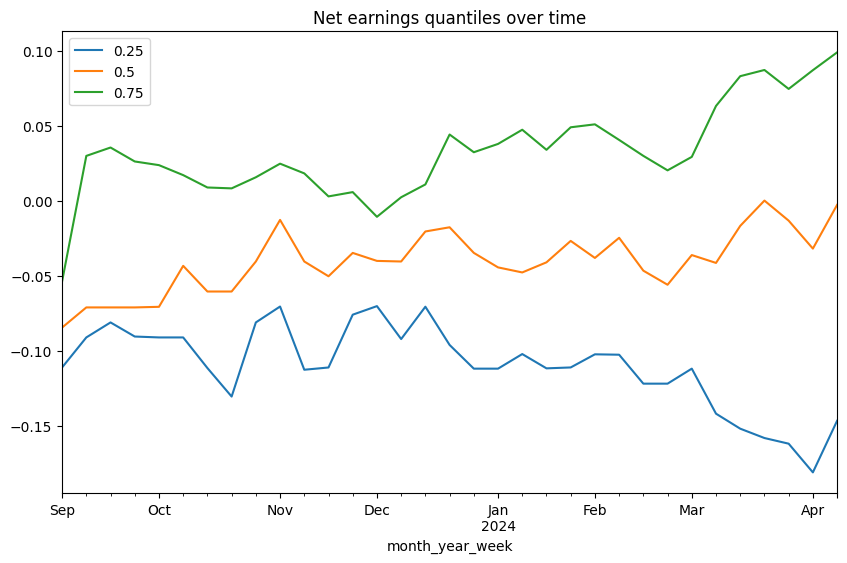

In [71]:
# plot new earnings from september 2023
all_trades[all_trades['creation_timestamp'] > '2023-09-01'].groupby('month_year_week')['net_earnings'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='Net earnings quantiles over time', figsize=(10,6))

<Axes: title={'center': 'ROI quantiles over time'}, xlabel='month_year_week'>

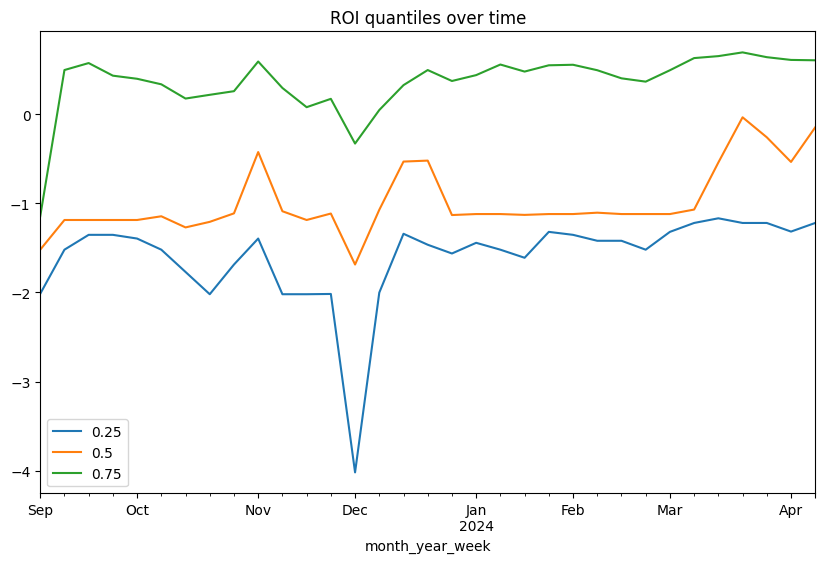

In [72]:
# roi from september 2023
all_trades[all_trades['creation_timestamp'] > '2023-09-01'].groupby('month_year_week')['roi'].quantile([0.25, 0.5, 0.75]).unstack().plot(title='ROI quantiles over time', figsize=(10,6))


In [8]:
del all_trades
gc.collect()

31